<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/v3_apptom_less_weight_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d manjuphoenix/tomatodataset
!kaggle datasets download -d manjuphoenix/appledataset

 99% 914M/923M [00:09<00:00, 136MB/s]
100% 923M/923M [00:09<00:00, 107MB/s]
 97% 323M/333M [00:04<00:00, 97.2MB/s]
100% 333M/333M [00:04<00:00, 72.8MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [6]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [7]:
!sudo mkdir /content/dataset
!sudo cp -rf /content/Tomato/* /content/dataset
!sudo cp -rf /content/Apple/* /content/dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.8)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 3993
The number of images in a training set is: 127776
The number of images in a validation set is: 27392
The number of images in a test set is: 5504
Dataset ImageFolder
    Number of datapoints: 91256
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [4]:
from PIL import Image
from pathlib import Path
from torch.autograd import Variable

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()

model = model.to(device)
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v4_tomato.pk1'))
model.load_state_dict(checkpoint)
model = model.to(device)

In [5]:
# !pip install torch-summary
from torchsummary import summary

summary(model, (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 256, 256]        1,216
├─LeakyReLU: 1-2                         [-1, 16, 256, 256]        --
├─MaxPool2d: 1-3                         [-1, 16, 128, 128]        --
├─Conv2d: 1-4                            [-1, 32, 130, 130]        4,640
├─LeakyReLU: 1-5                         [-1, 32, 130, 130]        --
├─MaxPool2d: 1-6                         [-1, 32, 65, 65]          --
├─Linear: 1-7                            [-1, 100]                 13,520,100
├─Linear: 1-8                            [-1, 8]                   808
Total params: 13,526,764
Trainable params: 13,526,764
Non-trainable params: 0
Total mult-adds (M): 170.04
Input size (MB): 0.75
Forward/backward pass size (MB): 12.13
Params size (MB): 51.60
Estimated Total Size (MB): 64.48


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 256, 256]        1,216
├─LeakyReLU: 1-2                         [-1, 16, 256, 256]        --
├─MaxPool2d: 1-3                         [-1, 16, 128, 128]        --
├─Conv2d: 1-4                            [-1, 32, 130, 130]        4,640
├─LeakyReLU: 1-5                         [-1, 32, 130, 130]        --
├─MaxPool2d: 1-6                         [-1, 32, 65, 65]          --
├─Linear: 1-7                            [-1, 100]                 13,520,100
├─Linear: 1-8                            [-1, 8]                   808
Total params: 13,526,764
Trainable params: 13,526,764
Non-trainable params: 0
Total mult-adds (M): 170.04
Input size (MB): 0.75
Forward/backward pass size (MB): 12.13
Params size (MB): 51.60
Estimated Total Size (MB): 64.48

In [6]:
# model.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
model.fc2 = nn.Linear(100, 14)

In [7]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=14, bias=True)
)

In [8]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [9]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [10]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [11]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 3993/3993 [05:42<00:00, 11.65it/s]


Train Loss: 2.107 | Accuracy: 30.366


100%|██████████| 856/856 [01:12<00:00, 11.76it/s]


Test Loss: 1.749 | Accuracy: 46.912

Epoch : 2


100%|██████████| 3993/3993 [05:56<00:00, 11.20it/s]


Train Loss: 1.583 | Accuracy: 52.700


100%|██████████| 856/856 [01:12<00:00, 11.81it/s]


Test Loss: 1.445 | Accuracy: 57.081

Epoch : 3


100%|██████████| 3993/3993 [05:51<00:00, 11.36it/s]


Train Loss: 1.369 | Accuracy: 58.858


100%|██████████| 856/856 [01:12<00:00, 11.80it/s]


Test Loss: 1.289 | Accuracy: 61.259

Epoch : 4


100%|██████████| 3993/3993 [05:49<00:00, 11.42it/s]


Train Loss: 1.241 | Accuracy: 62.299


100%|██████████| 856/856 [01:11<00:00, 11.96it/s]


Test Loss: 1.186 | Accuracy: 63.762

Epoch : 5


100%|██████████| 3993/3993 [05:45<00:00, 11.55it/s]


Train Loss: 1.155 | Accuracy: 64.401


100%|██████████| 856/856 [01:10<00:00, 12.07it/s]


Test Loss: 1.116 | Accuracy: 65.361

Epoch : 6


100%|██████████| 3993/3993 [05:43<00:00, 11.61it/s]


Train Loss: 1.101 | Accuracy: 65.294


100%|██████████| 856/856 [01:11<00:00, 12.00it/s]


Test Loss: 1.066 | Accuracy: 66.611

Epoch : 7


100%|██████████| 3993/3993 [05:40<00:00, 11.72it/s]


Train Loss: 1.049 | Accuracy: 66.762


100%|██████████| 856/856 [01:09<00:00, 12.31it/s]


Test Loss: 1.024 | Accuracy: 67.517

Epoch : 8


100%|██████████| 3993/3993 [05:37<00:00, 11.85it/s]


Train Loss: 1.020 | Accuracy: 67.424


100%|██████████| 856/856 [01:09<00:00, 12.32it/s]


Test Loss: 0.991 | Accuracy: 68.543

Epoch : 9


100%|██████████| 3993/3993 [05:35<00:00, 11.89it/s]


Train Loss: 0.989 | Accuracy: 68.219


100%|██████████| 856/856 [01:08<00:00, 12.45it/s]


Test Loss: 0.962 | Accuracy: 69.284

Epoch : 10


100%|██████████| 3993/3993 [05:34<00:00, 11.95it/s]


Train Loss: 0.956 | Accuracy: 69.130


100%|██████████| 856/856 [01:08<00:00, 12.45it/s]


Test Loss: 0.941 | Accuracy: 69.588

Epoch : 11


100%|██████████| 3993/3993 [05:49<00:00, 11.44it/s]


Train Loss: 0.939 | Accuracy: 69.652


100%|██████████| 856/856 [01:11<00:00, 12.04it/s]


Test Loss: 0.917 | Accuracy: 70.311

Epoch : 12


100%|██████████| 3993/3993 [05:38<00:00, 11.81it/s]


Train Loss: 0.915 | Accuracy: 70.226


100%|██████████| 856/856 [01:09<00:00, 12.35it/s]


Test Loss: 0.901 | Accuracy: 70.698

Epoch : 13


100%|██████████| 3993/3993 [05:41<00:00, 11.71it/s]


Train Loss: 0.899 | Accuracy: 70.937


100%|██████████| 856/856 [01:10<00:00, 12.12it/s]


Test Loss: 0.880 | Accuracy: 71.586

Epoch : 14


100%|██████████| 3993/3993 [05:41<00:00, 11.68it/s]


Train Loss: 0.880 | Accuracy: 71.455


100%|██████████| 856/856 [01:09<00:00, 12.31it/s]


Test Loss: 0.864 | Accuracy: 72.024

Epoch : 15


100%|██████████| 3993/3993 [05:35<00:00, 11.89it/s]


Train Loss: 0.867 | Accuracy: 71.753


100%|██████████| 856/856 [01:09<00:00, 12.38it/s]


Test Loss: 0.854 | Accuracy: 72.298

Epoch : 16


100%|██████████| 3993/3993 [05:38<00:00, 11.79it/s]


Train Loss: 0.856 | Accuracy: 72.218


100%|██████████| 856/856 [01:09<00:00, 12.28it/s]


Test Loss: 0.847 | Accuracy: 72.250

Epoch : 17


100%|██████████| 3993/3993 [05:34<00:00, 11.94it/s]


Train Loss: 0.843 | Accuracy: 72.532


100%|██████████| 856/856 [01:08<00:00, 12.47it/s]


Test Loss: 0.831 | Accuracy: 72.780

Epoch : 18


100%|██████████| 3993/3993 [05:34<00:00, 11.94it/s]


Train Loss: 0.831 | Accuracy: 73.148


100%|██████████| 856/856 [01:08<00:00, 12.47it/s]


Test Loss: 0.822 | Accuracy: 73.306

Epoch : 19


100%|██████████| 3993/3993 [05:33<00:00, 11.97it/s]


Train Loss: 0.829 | Accuracy: 72.932


100%|██████████| 856/856 [01:08<00:00, 12.48it/s]


Test Loss: 0.808 | Accuracy: 73.609

Epoch : 20


100%|██████████| 3993/3993 [05:33<00:00, 11.98it/s]


Train Loss: 0.818 | Accuracy: 73.411


100%|██████████| 856/856 [01:09<00:00, 12.39it/s]

Test Loss: 0.798 | Accuracy: 73.785


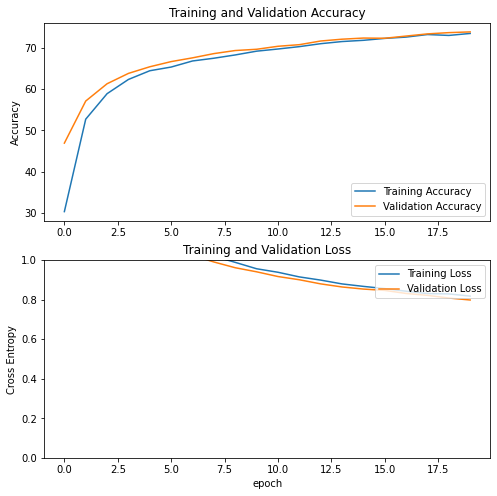

In [12]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

IndexError: ignored

In [ ]:
avg = 0
for i in range(12):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/12
print('Average accuracy = ', avg)

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v3_apptomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v3_apptomato_scripted.pt') # Save

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)